In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(
    "/kaggle/input/india-air-quality-data/data.csv",
    encoding="latin1",
    usecols=["no2"],
    low_memory=False
)

no2_data = pd.to_numeric(df["no2"], errors="coerce").dropna().values
print("Total NO2 samples:", len(no2_data))

Total NO2 samples: 419509


In [2]:
r = 102317248

ar = 0.5 * (r % 7)
br = 0.3 * ((r % 5) + 1)

print("r =", r)
print("ar =", ar)
print("br =", br)

r = 102317248
ar = 2.5
br = 1.2


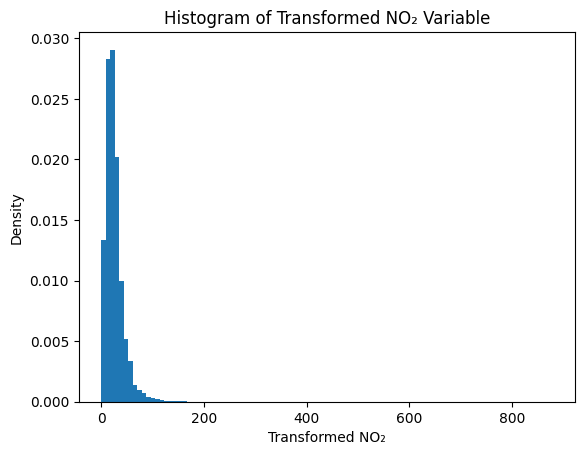

In [3]:
transformed_no2 = no2_data + ar * np.sin(br * no2_data)

# Plot histogram of transformed variable
plt.hist(transformed_no2, bins=100, density=True)
plt.xlabel("Transformed NO₂")
plt.ylabel("Density")
plt.title("Histogram of Transformed NO₂ Variable")
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

real_data_tensor = torch.tensor(transformed_no2, dtype=torch.float32).view(-1,1).to(device)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [7]:
generator_model = Generator().to(device)
discriminator_model = Discriminator().to(device)

loss_function = nn.BCELoss()
optimizer_G = optim.Adam(generator_model.parameters(), lr=0.0003)
optimizer_D = optim.Adam(discriminator_model.parameters(), lr=0.0003)

In [8]:
generator_model = Generator().to(device)
discriminator_model = Discriminator().to(device)

loss_function = nn.BCELoss()
optimizer_G = optim.Adam(generator_model.parameters(), lr=0.0003)
optimizer_D = optim.Adam(discriminator_model.parameters(), lr=0.0003)
num_epochs = 10000
batch_size = 256

for epoch_idx in range(num_epochs):
    idx = torch.randint(0, real_data_tensor.size(0), (batch_size,))
    real_batch = real_data_tensor[idx]

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Train Discriminator
    noise = torch.randn(batch_size, 1).to(device)
    fake_batch = generator_model(noise)

    loss_discriminator = loss_function(discriminator_model(real_batch), real_labels) + \
                         loss_function(discriminator_model(fake_batch.detach()), fake_labels)

    optimizer_D.zero_grad()
    loss_discriminator.backward()
    optimizer_D.step()

    # Train Generator
    noise = torch.randn(batch_size, 1).to(device)
    fake_batch = generator_model(noise)

    loss_generator = loss_function(discriminator_model(fake_batch), real_labels)

    optimizer_G.zero_grad()
    loss_generator.backward()
    optimizer_G.step()

    if epoch_idx % 500 == 0:
        print(f"Epoch {epoch_idx}, Discriminator Loss: {loss_discriminator.item():.4f}, Generator Loss: {loss_generator.item():.4f}")

Epoch 0, Discriminator Loss: 0.8524, Generator Loss: 0.6492
Epoch 500, Discriminator Loss: 1.3415, Generator Loss: 0.7207
Epoch 1000, Discriminator Loss: 1.3246, Generator Loss: 0.7728
Epoch 1500, Discriminator Loss: 1.3284, Generator Loss: 0.7169
Epoch 2000, Discriminator Loss: 1.3880, Generator Loss: 0.6727
Epoch 2500, Discriminator Loss: 1.3932, Generator Loss: 0.6905
Epoch 3000, Discriminator Loss: 1.4037, Generator Loss: 0.7505
Epoch 3500, Discriminator Loss: 1.3859, Generator Loss: 0.7198
Epoch 4000, Discriminator Loss: 1.4289, Generator Loss: 0.8843
Epoch 4500, Discriminator Loss: 1.3903, Generator Loss: 0.6376
Epoch 5000, Discriminator Loss: 1.4117, Generator Loss: 0.5875
Epoch 5500, Discriminator Loss: 1.3923, Generator Loss: 0.7120
Epoch 6000, Discriminator Loss: 1.3831, Generator Loss: 0.6034
Epoch 6500, Discriminator Loss: 1.3848, Generator Loss: 0.7424
Epoch 7000, Discriminator Loss: 1.3871, Generator Loss: 0.7309
Epoch 7500, Discriminator Loss: 1.4008, Generator Loss: 0.6

In [9]:
generator_model.eval()
with torch.no_grad():
    generated_samples = generator_model(torch.randn(50000, 1).to(device)).cpu().numpy()

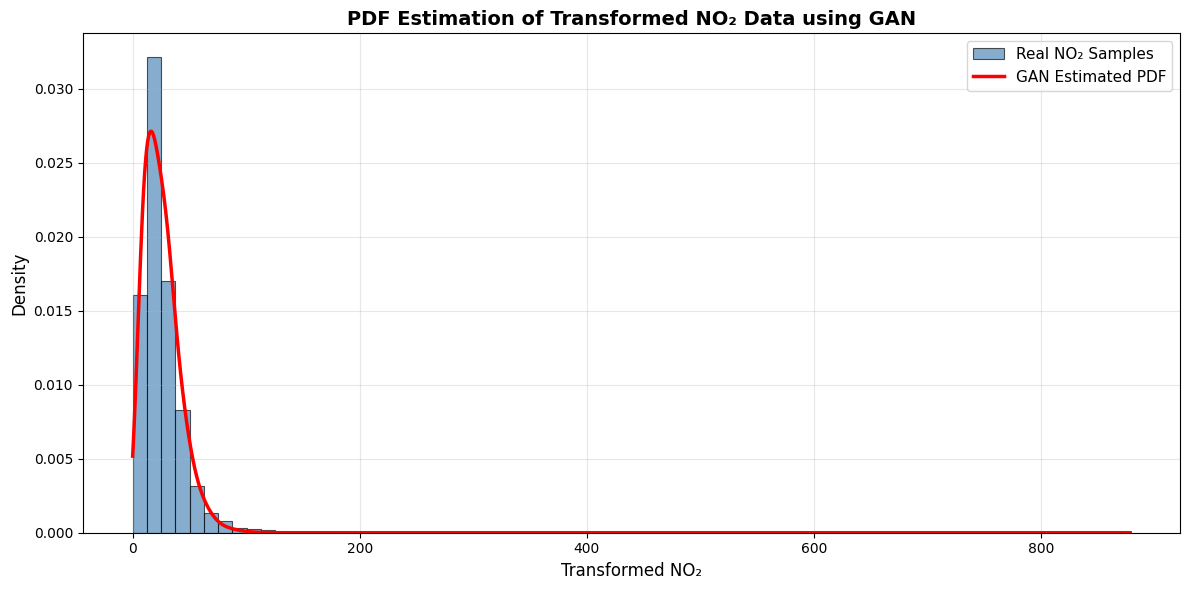

In [10]:
from scipy.stats import gaussian_kde

kde_estimator = gaussian_kde(generated_samples.flatten(), bw_method=0.35)
data_axis = np.linspace(transformed_no2.min(), transformed_no2.max(), 1000)
estimated_pdf = kde_estimator(data_axis)

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(transformed_no2, bins=70, density=True, alpha=0.65, label="Real NO₂ Samples", color='steelblue', edgecolor='black', linewidth=0.8)
ax.plot(data_axis, estimated_pdf, label="GAN Estimated PDF", linewidth=2.5, color='red')
ax.set_xlabel("Transformed NO₂", fontsize=12)
ax.set_ylabel("Density", fontsize=12)
ax.set_title("PDF Estimation of Transformed NO₂ Data using GAN", fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()